In [173]:
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras.layers as tfl

In [174]:
res = 224
# n_classes = 59
num_images = 990
base_path = '/content/drive/MyDrive/multiclass_semantic'

In [175]:
df = pd.read_csv(os.path.join(base_path, 'dont_open.csv'))
df.head()
value = df['value']
maping = df['map']

In [176]:
image_path = os.path.join(base_path, 'IMAGES_png')
image_names = sorted(os.listdir(image_path), key=lambda x: int(x.split('.')[0][4:]))
image_names_subset = image_names[:num_images]
images = [cv.resize(cv.cvtColor(cv.imread(os.path.join(image_path, image)), cv.COLOR_BGR2RGB), (res,res), interpolation=cv.INTER_NEAREST) for image in image_names_subset]
image_dataset = np.array(images)
# image_dataset = np.expand_dims(image_dataset, axis=-1)
image_dataset = image_dataset/255
image_dataset.shape

(990, 224, 224, 3)

In [177]:
mask_path = os.path.join(base_path, 'MASKS_png')
mask_names = sorted(os.listdir(mask_path), key=lambda x: int(x.split('.')[0][4:]))
mask_names_subset = mask_names[:num_images]
masks = [cv.resize(cv.imread(os.path.join(mask_path, mask),0), (res,res), interpolation=cv.INTER_NEAREST)  for mask in mask_names_subset]
mask_dataset = np.array(masks)
for i,v in zip(value, maping):
    mask_dataset[mask_dataset==i] = v

print(mask_dataset.shape)
n1_classes = len(np.unique(mask_dataset))
n1_classes

(990, 224, 224)


18

In [178]:
X_train, X_test, Y_train, Y_test = train_test_split(image_dataset, mask_dataset, test_size=0.15)

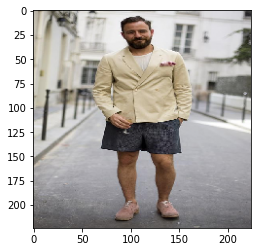

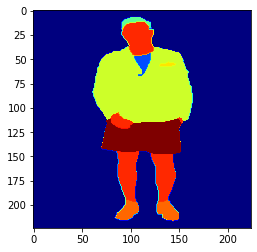

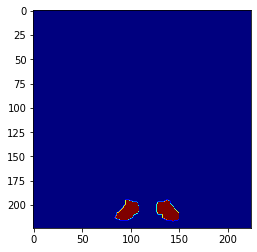

In [179]:
num = 1
cat = 12
for i,v in zip(X_train[:num],Y_train[:num]):
    plt.imshow(i)
    plt.show()
    plt.imshow(np.squeeze(v), cmap='jet')
    plt.show()
    v1 = tf.keras.utils.to_categorical(v)
    plt.imshow(v1[:,:,cat], cmap='jet')
    plt.show()

In [180]:
def enc_conv(input_layer=None, filters=32, MaxPool=True, dropout=0):
    conv = tfl.Conv2D(filters, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(input_layer)
    conv = tfl.Conv2D(filters, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)

    if dropout>0:
        conv = tfl.Dropout(dropout)(conv)

    if MaxPool:
        next_layer = tfl.MaxPool2D((2,2), strides=(2,2))(conv)
    else:
        next_layer = conv

    skip = conv
    return next_layer, skip


def dec_conv(dec_input, skip, filters=32):
    up = tfl.Conv2DTranspose(filters, (3,3), strides=(2,2), padding='same')(dec_input)

    merge = tfl.concatenate([up, skip], axis=3)

    conv = tfl.Conv2D(filters, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(merge)
    conv = tfl.Conv2D(filters, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    return conv

def U_Net(input_size=(res, res, 3), filters=64, n_classes=32):
    Input = tf.keras.Input(input_size)
    cblock1 = enc_conv(Input, filters)
    cblock2 = enc_conv(cblock1[0], filters*2, dropout=0.3)
    cblock3 = enc_conv(cblock2[0], filters*4, dropout=0.5)
    cblock4 = enc_conv(cblock3[0], filters*8, dropout=0.5)
    cblock5 = enc_conv(cblock4[0], filters*16, dropout=0.5, MaxPool=False) 
    ublock6 = dec_conv(cblock5[0], cblock4[1], filters*8)
    ublock7 = dec_conv(ublock6, cblock3[1], filters*4)
    ublock8 = dec_conv(ublock7, cblock2[1], filters*2)
    ublock9 = dec_conv(ublock8, cblock1[1], filters)

    conv9 = tfl.Conv2D(filters, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(ublock9)
    Output = tfl.Conv2D(n_classes, (1,1), padding='same')(conv9)

    model = tf.keras.Model(Input, Output)

    return model


In [199]:
model = U_Net(n_classes=n1_classes)
# model.load_weights(os.path.join(base_path, 'big_last_model_weights.h5'))
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [198]:
history = model.fit(X_train, Y_train, batch_size=32, epochs=80, validation_data=(X_test, Y_test))

Epoch 1/5
27/27 [==============================] - 38s 1s/step - loss: 0.6058 - accuracy: 0.8181 - val_loss: 0.6003 - val_accuracy: 0.8234
Epoch 2/5
27/27 [==============================] - 37s 1s/step - loss: 0.5976 - accuracy: 0.8197 - val_loss: 0.5981 - val_accuracy: 0.8241
Epoch 3/5
27/27 [==============================] - 37s 1s/step - loss: 0.5949 - accuracy: 0.8205 - val_loss: 0.5988 - val_accuracy: 0.8238
Epoch 4/5
27/27 [==============================] - 37s 1s/step - loss: 0.5955 - accuracy: 0.8200 - val_loss: 0.5971 - val_accuracy: 0.8238
Epoch 5/5
27/27 [==============================] - 37s 1s/step - loss: 0.5939 - accuracy: 0.8206 - val_loss: 0.5959 - val_accuracy: 0.8240


In [193]:
model.save(os.path.join(base_path, 'big_last_model.h5'))
model.save_weights(os.path.join(base_path, 'big_last_model_weights.h5'))
